In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time 

df = pd.read_pickle('data/pkl/PreciosBlue.xlsx.pkl')
df

,Fecha,Compra,Venta
0,2023-01-26,379.00,383.00
1,2023-01-25,377.00,381.00
2,2023-01-24,372.00,376.00
3,2023-01-23,372.00,376.00
4,2023-01-20,370.00,374.00
...,...,...,...
3212,2010-01-08,3.87,3.87
3213,2010-01-07,3.86,3.87
3214,2010-01-06,3.87,3.88
3215,2010-01-05,3.86,3.86


In [2]:
# renaming for fbprophet
df.rename(columns={'Fecha':'ds'}, inplace=True)
df.rename(columns={'Venta':'y'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,ds,Compra,y
0,0,2023-01-26,379.0,383.0
1,1,2023-01-25,377.0,381.0
2,2,2023-01-24,372.0,376.0
3,3,2023-01-23,372.0,376.0
4,4,2023-01-20,370.0,374.0


In [3]:
df.rename(columns={'Fecha':'ds'}, inplace=True)

In [4]:
df = df[df['ds'] >= '2018-01-01']

df

,index,ds,Compra,y
0,0,2023-01-26,379.00,383.00
1,1,2023-01-25,377.00,381.00
2,2,2023-01-24,372.00,376.00
3,3,2023-01-23,372.00,376.00
4,4,2023-01-20,370.00,374.00
...,...,...,...,...
1266,1266,2018-01-08,19.18,19.58
1267,1267,2018-01-05,19.05,19.45
1268,1268,2018-01-04,19.01,19.41
1269,1269,2018-01-03,18.89,19.29


In [5]:
df.drop(['Compra'], axis=1)

,index,ds,y
0,0,2023-01-26,383.00
1,1,2023-01-25,381.00
2,2,2023-01-24,376.00
3,3,2023-01-23,376.00
4,4,2023-01-20,374.00
...,...,...,...
1266,1266,2018-01-08,19.58
1267,1267,2018-01-05,19.45
1268,1268,2018-01-04,19.41
1269,1269,2018-01-03,19.29


In [6]:
df = df.sort_values(by='ds')

In [7]:
df['y'].round(2).describe()

count    1271.000000
mean      130.844146
std        89.874549
min        19.250000
25%        43.800000
50%       132.000000
75%       192.500000
max       383.000000
Name: y, dtype: float64

In [8]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(df)

c:\Users\rodri\anaconda3.1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
16:58:46 - cmdstanpy - INFO - Chain [1] start processing
16:58:49 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future_dataset= prophet_model.make_future_dataframe(periods=1, freq='y') # Data para el proximo año
future_dataset.tail()

,ds
1233,2023-01-23
1234,2023-01-24
1235,2023-01-25
1236,2023-01-26
1237,2023-12-31


In [10]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,28.122241,14.740901,43.014353
1,2018-01-03,29.139253,15.776895,42.449986
2,2018-01-04,29.376075,16.129431,43.868245
3,2018-01-05,29.490252,16.109093,42.945371
4,2018-01-08,29.485410,15.520700,44.114347


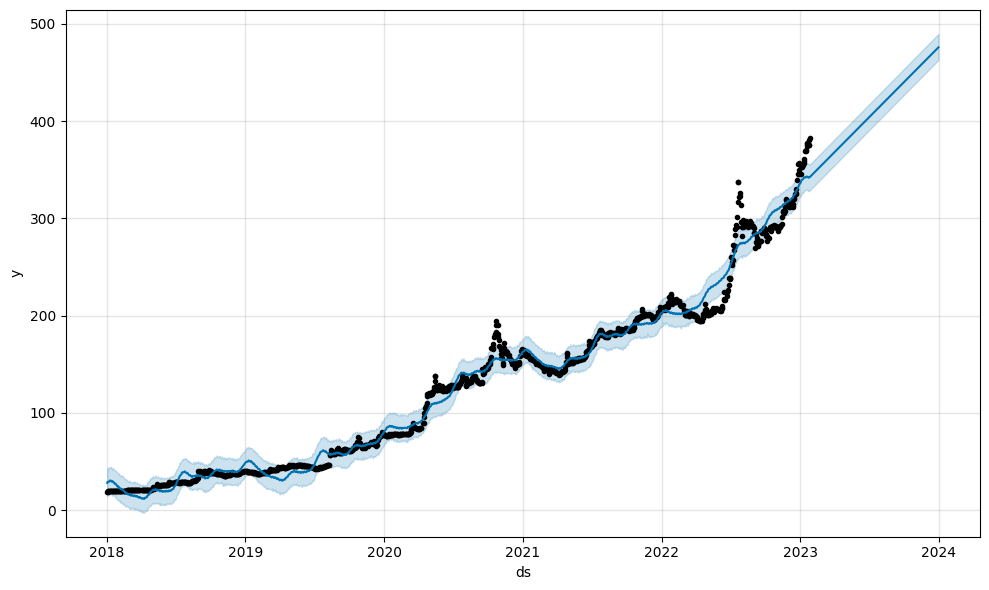

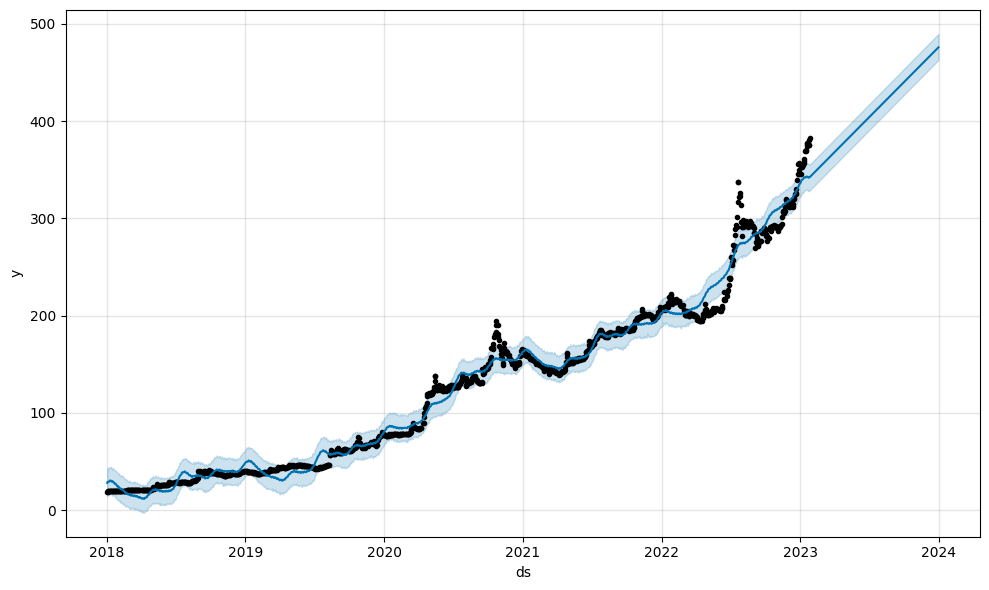

In [11]:
prophet_model.plot(pred)

In [12]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [13]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

16:58:59 - cmdstanpy - INFO - Chain [1] start processing
17:00:41 - cmdstanpy - INFO - Chain [1] done processing


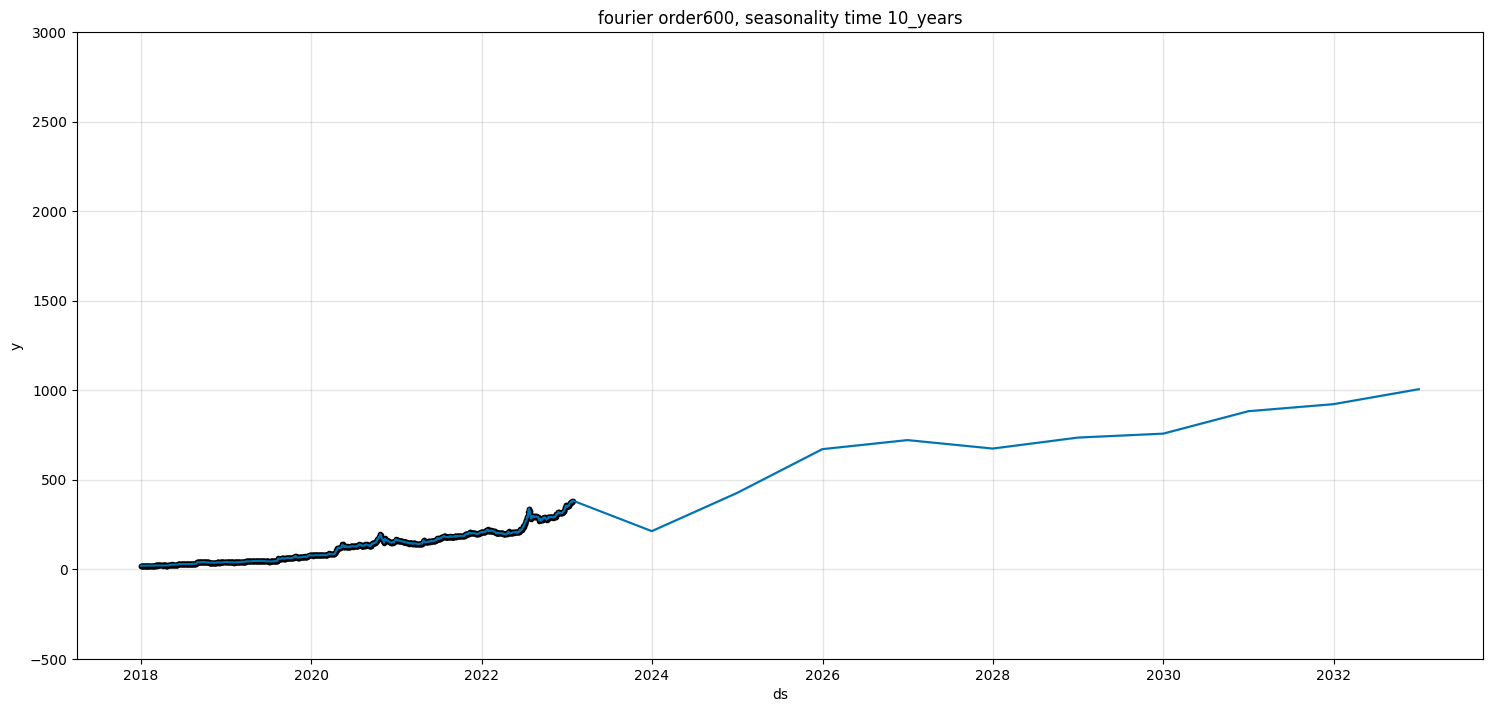

Total Execution Time 109.38705229759216 seconds


In [14]:
import time

training_set = df
validation_set = df 

ten_years = fb_prophet_function(data=training_set, future_years=10, seasonality_name='10_years', seasonality_val=365*10, seasonality_fourier=600,seasonality_mode='additive')

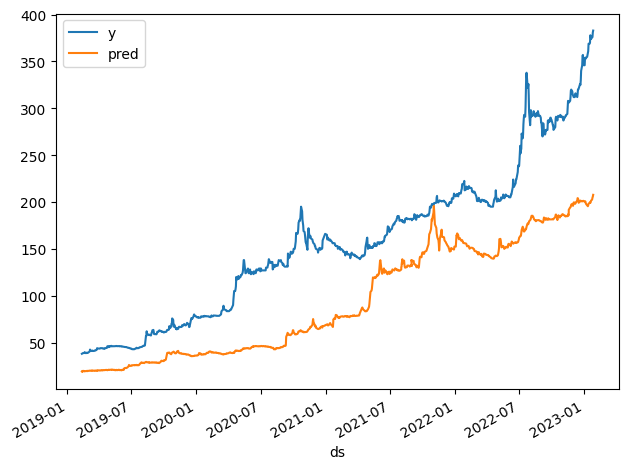

In [15]:
plot_valid(validation_set, 1000, ten_years)

In [16]:
pred = pred[['ds', 'yhat']]

pred

,ds,yhat
0,2018-01-02,28.122241
1,2018-01-03,29.139253
2,2018-01-04,29.376075
3,2018-01-05,29.490252
4,2018-01-08,29.485410
...,...,...
1233,2023-01-23,341.914082
1234,2023-01-24,342.175989
1235,2023-01-25,342.684680
1236,2023-01-26,342.453040


In [17]:
validation_set = validation_set[['ds', 'y']]

validation_set

,ds,y
1270,2018-01-02,19.25
1269,2018-01-03,19.29
1268,2018-01-04,19.41
1267,2018-01-05,19.45
1266,2018-01-08,19.58
...,...,...
4,2023-01-20,374.00
3,2023-01-23,376.00
2,2023-01-24,376.00
1,2023-01-25,381.00


In [18]:
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred

,ds,yhat
0,2018-01-02,28.122241
1,2018-01-03,29.139253
2,2018-01-04,29.376075
3,2018-01-05,29.490252
4,2018-01-08,29.485410
...,...,...
1232,2023-01-20,342.798039
1233,2023-01-23,341.914082
1234,2023-01-24,342.175989
1235,2023-01-25,342.684680


In [19]:
merged1 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged1[['ds', 'y']]
pred_ds_yhat = merged1[['ds', 'yhat']]


In [20]:
validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())

C:\Users\rodri\AppData\Local\Temp\ipykernel_16120\2616818827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_16120\2616818827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())


In [21]:
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)

C:\Users\rodri\AppData\Local\Temp\ipykernel_16120\476390056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
C:\Users\rodri\AppData\Local\Temp\ipykernel_16120\476390056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)


In [22]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse1 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse1 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae1)
print("Mean Squared Error: ", mse1)
print("Root Mean Squared Error: ", rmse1)


Mean Absolute Error:  3.826518946993374
Mean Squared Error:  56.010215968476665
Root Mean Squared Error:  7.483997325525756


In [23]:
df = df[df['ds'] >= '2021-01-01']

df

,index,ds,Compra,y
535,535,2021-01-04,159.0,165.0
534,534,2021-01-05,154.0,160.0
533,533,2021-01-06,154.0,160.0
532,532,2021-01-07,156.0,162.0
531,531,2021-01-08,155.0,161.0
...,...,...,...,...
4,4,2023-01-20,370.0,374.0
3,3,2023-01-23,372.0,376.0
2,2,2023-01-24,372.0,376.0
1,1,2023-01-25,377.0,381.0


17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:01:04 - cmdstanpy - INFO - Chain [1] done processing


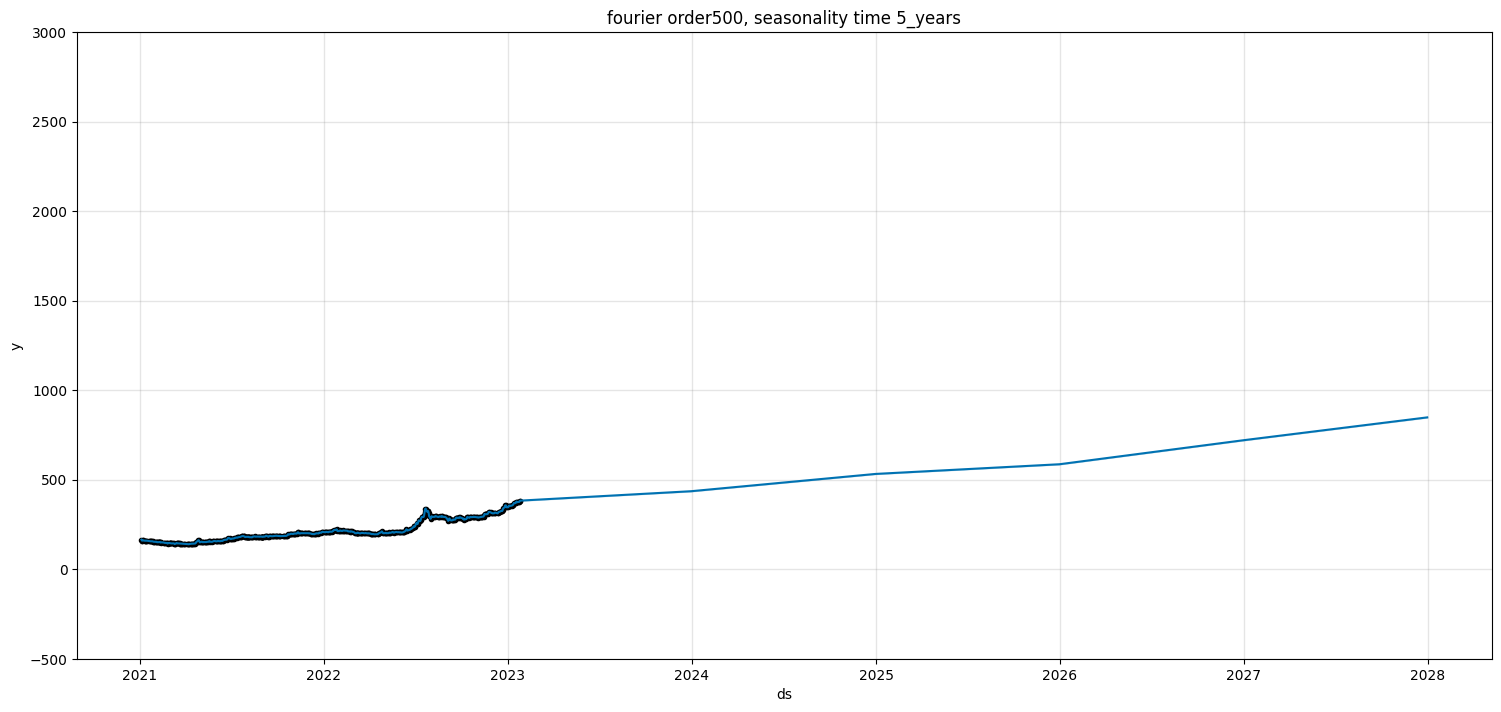

Total Execution Time 19.471239805221558 seconds


In [24]:
training_set = df
validation_set = df

five_years_model = fb_prophet_function(data=training_set, future_years=5, seasonality_name='5_years', seasonality_val=365*5, seasonality_fourier=500,seasonality_mode='additive')

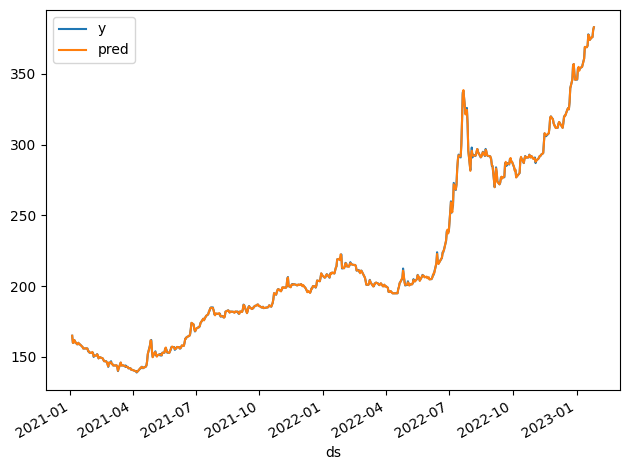

In [25]:
plot_valid(validation_set, 1000, five_years_model)

In [26]:
from prophet.diagnostics import cross_validation, performance_metrics

model = Prophet()
model.fit(df)

df_cv = cross_validation(model, initial='360 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, rolling_window=0.1) 
 
df_p.head()

17:01:06 - cmdstanpy - INFO - Chain [1] start processing
17:01:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

17:01:06 - cmdstanpy - INFO - Chain [1] start processing
17:01:06 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,192.497892,13.874361,11.868316,0.056443,0.043477,0.054342,0.0
1,40 days,357.879938,18.917715,16.190506,0.078244,0.070028,0.074223,0.0
2,41 days,398.884350,19.972089,17.327313,0.083922,0.070175,0.079436,0.0
3,42 days,435.816188,20.876211,18.372529,0.089081,0.079076,0.084184,0.0
4,43 days,476.558513,21.830220,19.389467,0.094165,0.080750,0.088809,0.0


In [ ]:
from sklearn.metrics import mean_squared_error
pred = pred[['ds', 'yhat']]

pred
validation_set = validation_set[['ds', 'y']]

validation_set
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred
merged2 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged2[['ds', 'y']]
pred_ds_yhat = merged2[['ds', 'yhat']]

validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)
import math

mae2 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse2 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse2 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae2)
print("Mean Squared Error: ", mse2)
print("Root Mean Squared Error: ", rmse2)


In [ ]:
from prophet import Prophet

five_years_model = Prophet(seasonality_mode='additive', seasonality_prior_scale=1, 
                         yearly_seasonality=True, weekly_seasonality=False, 
                         daily_seasonality=False)


In [ ]:
five_years_model.add_seasonality(name='1_years', period=365*1, fourier_order=140)

In [ ]:
import datetime

today = datetime.datetime.now()
next_month = today + datetime.timedelta(days=90)
start_date = today.strftime("%Y-%m-%d")
end_date = next_month.strftime("%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
next_month = pd.DataFrame({"ds": date_range})


In [ ]:
five_years_model.fit(training_set)

prediction = five_years_model.predict(next_month)

11:14:39 - cmdstanpy - INFO - Chain [1] start processing
11:14:49 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
values = prediction['yhat']

values_new = pd.DataFrame(values)

values_new = values_new.rename(columns={'yhat':'Values'})

values_new

,Values
0,382.538027
1,378.656947
2,379.424650
3,380.089699
4,378.706874
...,...
86,384.766237
87,384.521992
88,388.619913
89,393.227263


In [ ]:
# import the datetime library
import datetime

# define the start date (today + 1) and the number of days in the range
start_date = datetime.datetime.today() + datetime.timedelta(days=1)
num_days = len(values_new.index)

# create the date range
date_range = [start_date.date() + datetime.timedelta(days=i) for i in range(num_days)]

# set the index of the dataframe to the date range
values_new.index = date_range

values_new


,Values
2023-01-28,382.538027
2023-01-29,378.656947
2023-01-30,379.424650
2023-01-31,380.089699
2023-02-01,378.706874
...,...
2023-04-24,384.766237
2023-04-25,384.521992
2023-04-26,388.619913
2023-04-27,393.227263


In [ ]:
values_new.to_excel("data/xlsx/values_newBlue.xlsx")

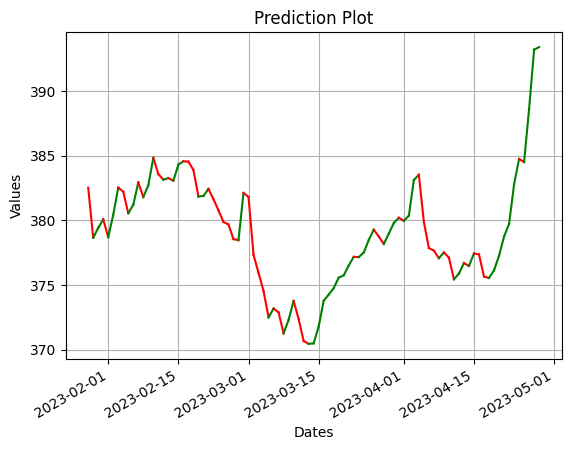

In [ ]:
x = values_new.index
y = values_new['Values']
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'g'
    else:
        color = 'r'
    plt.plot(x[i-1:i+1], y[i-1:i+1], color=color)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Prediction Plot")
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = []
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'green'
    else:
        color = 'red'
    trace = go.Scatter(x=x[i-1:i+1], y=y[i-1:i+1], mode='lines', line=dict(color=color, width=1), showlegend=False)
    data.append(trace)

layout = go.Layout(title='Prediccion Dolar Blue', xaxis=dict(title='Fecha'), yaxis=dict(title='Valores'))
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [ ]:
with open('data/html/Predicciones/Pred_DolarBlue.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))